# Introduction

In this notebook we demonstrate the use of LDA (Latent Dirichlet Allocation) generative statistical model for Information Retrieval technique to make trace link recovery between Use Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each use case content as an entire document that must be returned to the query made

## Import Libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, pairwise_distances, pairwise
from sklearn.externals import joblib
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix

from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 

import datetime
import pprint
from enum import Enum

import warnings; warnings.simplefilter('ignore')

## Load Dataset and Preprocessing

In [26]:
trace_df = pd.read_csv('../../data/jEdit/jEditDataset/oracle/output/trace_matrix.csv')
artfs_desc_df = pd.read_csv('../../data/jEdit/jEditDataset/oracle/output/artifacts_descriptions.csv', sep="|")

use_cases_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Use Case ID')]
bug_reports_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Bug Number')]

corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

use_cases_names = use_cases_df.artf_name
bug_reports_names = bug_reports_df.artf_name

# LSI Model

#### Model Hyperparameters

In [27]:
class LDA_Model_Hyperp(Enum):
    NAME = 'lda__name'
    MIN_COSINE_SIMILARITY_THRESHOLD = 'lda__min_cosine_similarity_threshold'
    VECTORIZER = 'lda__vectorizer'
    VECTORIZER_STOP_WORDS = 'lda__vectorizer__stop_words'
    VECTORIZER_TOKENIZER = 'lda__vectorizer__tokenizer'
    VECTORIZER_USE_IDF = 'lda__vectorizer__use_idf'
    VECTORIZER_SMOOTH_IDF = 'lda__vectorizer__smooth_idf'
    VECTORIZER_NGRAM_RANGE = 'lda__vectorizer__ngram_range'
    LDA_MODEL = 'lda__lda_model'
    LDA_MODEL_N_COMPONENTS = 'lda__lda_model__n_components'
    LDA_MODEL_RANDOM_STATE = 'lda__lda_model__random_state'

#### Tokenizers

In [28]:
"""
Others stemmers are not relevant for our analysis:
 . RSLP Stemmer: portuguese language
 . ISRIS Stemmer: returns Arabic root for the given token 
 . Regexp Stemmer: uses regulax expressions to identify morphological affixes
 
Relevant Stemmers/Lemmatizers are implemented below. 
"""

class WordNetBased_LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(token) for token in word_tokenize(doc)]

class LancasterStemmerBased_Tokenizer(object):
    def __init__(self):
        self.stemmer = LancasterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(token) for token in word_tokenize(doc)]

class PorterStemmerBased_Tokenizer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(token) for token in word_tokenize(doc)]
    
class SnowballStemmerBased_Tokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.stemmer.stem(token) for token in word_tokenize(doc)]

#### Jensen-Shannon Divergence

In [29]:
def jsd(x,y): #Jensen-shannon divergence
    import warnings
    warnings.filterwarnings("ignore", category = RuntimeWarning)
    x = np.array(x)
    y = np.array(y)
    d1 = x*np.log2(2*x/(x+y))
    d2 = y*np.log2(2*y/(x+y))
    d1[np.isnan(d1)] = 0
    d2[np.isnan(d2)] = 0
    d = 0.5*np.sum(d1+d2)    
    return d

#### Model Defintion

In [30]:
"""
params_dict = {
    'lda__min_cosine_similarity_threshold' : .9,
    'lda__name' : 'LDA',
    'lda__vectorizer' : TfidfVectorizer(),
    'lda__vectorizer__stop_words' : 'english',
    'lda__vectorizer__tokenizer' : Tokenizer(),
    'lda__vectorizer__use_idf' : True,          # optional if type(Vectorizer) == TfidfVectorizer
    'lda__vectorizer__smooth_idf' : True,       # optional if type(Vectorizer) == TfidfVectorizer
    'lda__vectorizer__ngram_range' : (1,2),
    'lda__lda_model' : TruncatedSVD(),
    'lda__lda_model__n_components' : 5
}
"""
class LDA:
    def __init__(self, **kwargs):
        self._corpus_matrix = None
        self._query_vector = None
        
        self.name = None
        self.min_cosine_similarity_threshold = None
        self.trace_links_df = None
        self.vectorizer = None
        self.lda_model = LatentDirichletAllocation()
        
        self.set_name(**kwargs)
        self.set_min_cosine_similarity_threshold(**kwargs)
        self.set_vectorizer(**kwargs)
        self.set_lda_model(**kwargs)
    
    def set_name(self, **kwargs):
        self.name = 'LDA' if LDA_Model_Hyperp.NAME.value not in kwargs.keys() else kwargs[LDA_Model_Hyperp.NAME.value]
    
    def set_min_cosine_similarity_threshold(self, **kwargs):
        self.min_cosine_similarity_threshold = .80 if LDA_Model_Hyperp.MIN_COSINE_SIMILARITY_THRESHOLD.value not in kwargs.keys() else kwargs[LDA_Model_Hyperp.MIN_COSINE_SIMILARITY_THRESHOLD.value]
    
    def set_vectorizer(self, **kwargs):
        self.vectorizer = TfidfVectorizer(stop_words='english',
                                             use_idf=True, 
                                             smooth_idf=True) if LDA_Model_Hyperp.VECTORIZER.value not in kwargs.keys() else kwargs[LDA_Model_Hyperp.VECTORIZER.value]
        
        vec_params = {key.split('__')[2]:kwargs[key] for key,val in kwargs.items() if '__vectorizer__' in key}
        self.vectorizer.set_params(**vec_params)
    
    def set_lda_model(self, **kwargs):      
        lda_model_params = {key.split('__')[2]:kwargs[key] for key,val in kwargs.items() if '__lda_model__' in key}
        self.lda_model.set_params(**lda_model_params)
    
    def recover_links(self, corpus, query, use_cases_names, bug_reports_names):
        self._corpus_matrix = self.vectorizer.fit_transform(corpus)
        self._query_vector = self.vectorizer.transform(query)
        
        out_1 = self.lda_model.fit_transform(self._corpus_matrix)
        out_2 = self.lda_model.transform(self._query_vector)
        
        # D 14 x 10
        self._cosine_sim_matrix = pairwise.cosine_similarity(out_1,
                                                            out_2)
        
        self.trace_links_df = pd.DataFrame(index = use_cases_names, 
                                           columns = bug_reports_names,
                                           data = self._cosine_sim_matrix)

        for col in self.trace_links_df.columns:
            self.trace_links_df[col] = [1 if x >= self.min_cosine_similarity_threshold else 0 for x in self.trace_links_df[col]]

    def model_setup(self):
        return {"Setup" : 
                  [
                      {"LDA Minimum Cosine Similarity Threshold" : self.min_cosine_similarity_threshold},
                      {"LDA Model" : self.lda_model.get_params()},
                      {"Vectorizer" : self.vectorizer.get_params()},
                      {"Vectorizer Type" : type(self.vectorizer)}
                  ]
               }
    
    def get_name(self):
        return self.name
    
    def get_cosine_sim_matrix(self):
        return self._cosine_sim_matrix
    
    def get_query_vector(self):
        return self._query_vector
    
    def get_corpus_matrix(self):
        return self._corpus_matrix
    
    def get_min_cosine_similarity_threshold(self):
        return self.min_cosine_similarity_threshold

### Oracle Loader

In [31]:
class OracleLoader:
    def __init__(self, rows_names, columns_names):
        self.oracle = None
        self._columns_names = columns_names
        self._rows_names = rows_names
    
    def load(self):
        self.oracle = pd.DataFrame(columns=list(self._columns_names))
        self.oracle.insert(0, 'artf_name', list(self._rows_names))
        
        for index, row in trace_df.iterrows():
            idx = self.oracle[self.oracle.artf_name == row['trg_artf']].index
            self.oracle.at[idx, row['src_artf']] = row['link']

        self.oracle.set_index('artf_name', inplace=True)

### Model Evaluator

In [32]:
class ModelEvaluator:
    def __init__(self, oracle, model):
        self.model = model
        self.oracle = oracle
        self.recovered_links = model.trace_links_df
        
        self.eval_df = pd.DataFrame(columns=['precision','recall','fscore','support'])
        self.mean_precision = -1
        self.mean_recall = -1
        self.mean_fscore = -1
    
    def evaluate_model(self, verbose=False, file=None):
        y_true = csr_matrix(self.oracle.values, dtype=int)
        y_pred = csr_matrix(self.recovered_links.values, dtype=int)
        
        p, r, f, sp = precision_recall_fscore_support(y_true, y_pred)

        i = 0
        for idx, row in self.oracle.iteritems():
            self.eval_df.at[idx, 'precision'] = p[i]
            self.eval_df.at[idx, 'recall'] = r[i]
            self.eval_df.at[idx, 'fscore'] = f[i]
            self.eval_df.at[idx, 'support'] = sp[i]
            i += 1
        
        self.mean_precision = self.eval_df.precision.mean()
        self.mean_recall = self.eval_df.recall.mean()
        self.mean_fscore = self.eval_df.fscore.mean()
        
        if verbose:
            self.print_report(file)
    
    def print_report(self, file=None):
        dic = self.model.model_setup()
        dic['Measures'] = {}
        dic['Measures']['Mean Precision of {}'.format(self.model.get_name())] = self.get_mean_precision()
        dic['Measures']['Mean Recall of {}'.format(self.model.get_name())] = self.get_mean_recall()
        dic['Measures']['Mean FScore of {}'.format(self.model.get_name())] = self.get_mean_fscore()
        
        if file is None:    
            pprint.pprint(dic)
        else:
            file.write(pprint.pformat(dic))
        
    def plot_precision_vs_recall(self):
        plt.figure(figsize=(6,6))
        plt.plot(self.eval_df.recall, self.eval_df.precision, 'ro', label='Precision vs Recall')

        plt.ylabel('Precision')
        plt.xlabel('Recall')

        plt.axis([0, 1.1, 0, 1.1])
        plt.title("Precision vs Recall Plot - " + self.model.get_name())
        plt.show()
    
    def save_log(self):
        print("\nSaving model log...")
        with open('../logs/' + str(datetime.datetime.now()) + '.txt', 'a') as f:
            evaluator.evaluate_model(verbose=True, file=f)
        print("Model log saved with success!")
            
    def get_mean_precision(self):
        return self.mean_precision
    
    def get_mean_recall(self):
        return self.mean_recall
    
    def get_mean_fscore(self):
        return self.mean_fscore

## Evaluate Recovering Efficiency

In order to evaluate the efficiency of the algorithm tested (LSI), we use common metrics applied in the field of IR:

    * Precision
    * Recall
    * F1-score

### Load Oracle

In [33]:
orc = OracleLoader(use_cases_names, bug_reports_names)
orc.load()

### Function to Generate Hyperparameters

In [34]:
from itertools import product

def generate_params_comb_list(**kwargs):
    list_params = []
    for key, values in kwargs.items():
        aux_list = []
        for v in values:
            aux_list.append((key, v))
        list_params.append(aux_list)
    
    list_tuples = list(product(*list_params))
    
    list_dicts = []
    for ex_tup in list_tuples:
        dic = {}
        for in_tup in ex_tup:
            dic[in_tup[0]] = in_tup[1]
        list_dicts.append(dic)
        
    return list_dicts

#### Plot Results Function

In [35]:
def plot_results_2(results_dict):
    fig, ax = plt.subplots(figsize=(10,100)) 
    df = pd.DataFrame(results_dict)
    df.set_index('model', inplace=True)       
    ax = sns.heatmap(df, vmin=0, vmax=1, linewidths=.5, cmap="Greens", annot=True, cbar=False, ax=ax)
    

### Test with One Combination of Hyperparameters

Performing model optimizations...
------------ Report -------------------

Total of Analyzed Hyperparameters Combinations: 1

Best Model and Hyperparameters Found: LDA_Model_0

{'Measures': {'Mean FScore of LDA_Model_0': 0.32482993197278903,
              'Mean Precision of LDA_Model_0': 0.21428571428571427,
              'Mean Recall of LDA_Model_0': 0.7857142857142857},
 'Setup': [{'LDA Minimum Cosine Similarity Threshold': 0.75},
           {'LDA Model': {'batch_size': 128,
                          'doc_topic_prior': None,
                          'evaluate_every': -1,
                          'learning_decay': 0.7,
                          'learning_method': None,
                          'learning_offset': 10.0,
                          'max_doc_update_iter': 100,
                          'max_iter': 10,
                          'mean_change_tol': 0.001,
                          'n_components': 100,
                          'n_jobs': 1,
                          'n_topic

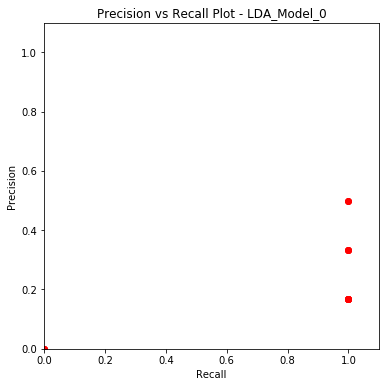

In [36]:
all_hyperparams = {
    LDA_Model_Hyperp.MIN_COSINE_SIMILARITY_THRESHOLD.value : [.75],
    LDA_Model_Hyperp.LDA_MODEL_N_COMPONENTS.value: [100],
    LDA_Model_Hyperp.LDA_MODEL_RANDOM_STATE.value : [2],
    LDA_Model_Hyperp.VECTORIZER_NGRAM_RANGE.value: [(1,1)],
    LDA_Model_Hyperp.VECTORIZER.value : [CountVectorizer(stop_words='english')],
    LDA_Model_Hyperp.VECTORIZER_TOKENIZER.value : [LancasterStemmerBased_Tokenizer()]    
}

hyperparams = generate_params_comb_list(**all_hyperparams)

print('Performing model optimizations...')
best_precision = 0.0
best_recall = 0.0
best_fscore = 0.0
best_model = None

results = {'precision': [], 'recall': [], 'fscore': [], 'model': []}

i = 0
for hyperp in hyperparams:
    hyperp[LDA_Model_Hyperp.NAME.value] = 'LDA_Model_{}'.format(i)
    current_model = LDA(**hyperp)
    current_model.recover_links(corpus, query, use_cases_names, bug_reports_names)
    
    evaluator = ModelEvaluator(orc.oracle, current_model)
    evaluator.evaluate_model()
    
    if best_recall <= evaluator.get_mean_recall():
        best_recall = evaluator.get_mean_recall()
        best_precision = evaluator.get_mean_precision()
        best_fscore = evaluator.get_mean_fscore()
        best_model = current_model
    
    results['precision'].append(evaluator.get_mean_precision())
    results['recall'].append(evaluator.get_mean_recall())
    results['fscore'].append(evaluator.get_mean_fscore())
    results['model'].append(current_model.get_name())
    
    i += 1

print("------------ Report -------------------\n")
print("Total of Analyzed Hyperparameters Combinations: {}".format(len(hyperparams)))

print("\nBest Model and Hyperparameters Found: {}\n".format(best_model.get_name()))            
evaluator = ModelEvaluator(orc.oracle, best_model)
evaluator.evaluate_model(verbose=True)

print("\nPlot Precision vs Recall - Best Model")
evaluator.plot_precision_vs_recall()

#print("\nHeatmap of All Models")
#plot_results_2(results)

### Find The Best Model

Performing model optimizations...
------------ Report -------------------

Total of Analyzed Hyperparameters Combinations: 400

Best Model and Hyperparameters Found: LDA_Model_385

{'Measures': {'Mean FScore of LDA_Model_385': 0.23426573426573422,
              'Mean Precision of LDA_Model_385': 0.13571428571428573,
              'Mean Recall of LDA_Model_385': 1.0},
 'Setup': [{'LDA Minimum Cosine Similarity Threshold': 0.95},
           {'LDA Model': {'batch_size': 128,
                          'doc_topic_prior': None,
                          'evaluate_every': -1,
                          'learning_decay': 0.7,
                          'learning_method': None,
                          'learning_offset': 10.0,
                          'max_doc_update_iter': 100,
                          'max_iter': 10,
                          'mean_change_tol': 0.001,
                          'n_components': 100,
                          'n_jobs': 1,
                          'n_topics': N

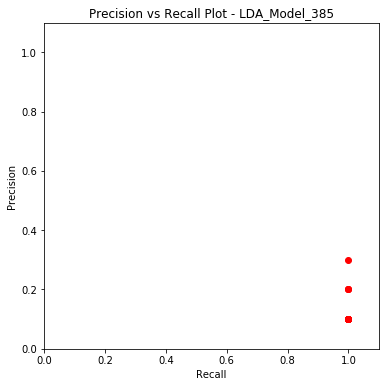


Heatmap of All Models


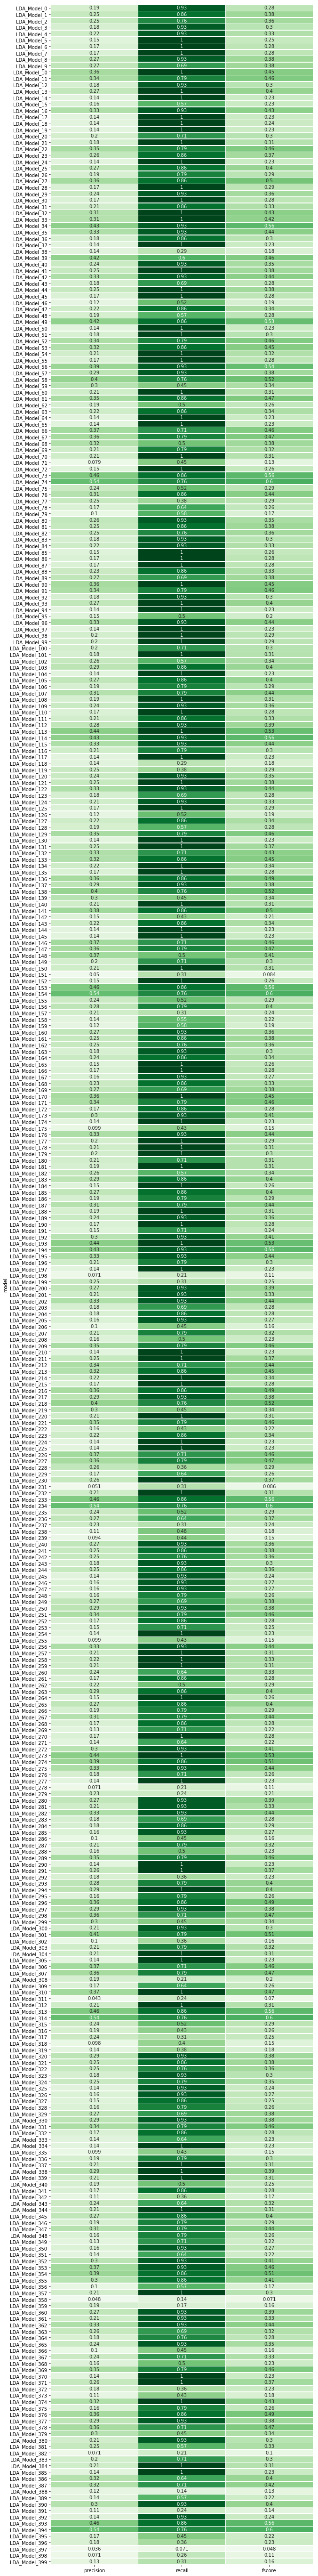

In [37]:
all_hyperparams = {
    LDA_Model_Hyperp.MIN_COSINE_SIMILARITY_THRESHOLD.value : [.75, .80, .85, .90, .95],
    LDA_Model_Hyperp.LDA_MODEL_N_COMPONENTS.value: [5,10,20,50,100],
    LDA_Model_Hyperp.LDA_MODEL_RANDOM_STATE.value : [2],
    LDA_Model_Hyperp.VECTORIZER_NGRAM_RANGE.value: [(1,1), (1,2)],
    LDA_Model_Hyperp.VECTORIZER.value : [TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True), 
                         CountVectorizer(stop_words='english')],
    LDA_Model_Hyperp.VECTORIZER_TOKENIZER.value : [PorterStemmerBased_Tokenizer(), LancasterStemmerBased_Tokenizer(), 
                                                   WordNetBased_LemmaTokenizer(), SnowballStemmerBased_Tokenizer()]
}

hyperparams = generate_params_comb_list(**all_hyperparams)

print('Performing model optimizations...')
best_precision = 0.0
best_recall = 0.0
best_fscore = 0.0
best_model = None

results = {'precision': [], 'recall': [], 'fscore': [], 'model': []}

i = 0
for hyperp in hyperparams:
    hyperp[LDA_Model_Hyperp.NAME.value] = 'LDA_Model_{}'.format(i)
    current_model = LDA(**hyperp)
    current_model.recover_links(corpus, query, use_cases_names, bug_reports_names)
    
    evaluator = ModelEvaluator(orc.oracle, current_model)
    evaluator.evaluate_model()

    if best_recall <= evaluator.get_mean_recall():
        best_recall = evaluator.get_mean_recall()
        best_precision = evaluator.get_mean_precision()
        best_fscore = evaluator.get_mean_fscore()
        best_model = current_model
    
    results['precision'].append(evaluator.get_mean_precision())
    results['recall'].append(evaluator.get_mean_recall())
    results['fscore'].append(evaluator.get_mean_fscore())
    results['model'].append(current_model.get_name())
    
    i += 1

print("------------ Report -------------------\n")
print("Total of Analyzed Hyperparameters Combinations: {}".format(len(hyperparams)))

print("\nBest Model and Hyperparameters Found: {}\n".format(best_model.get_name()))            
evaluator = ModelEvaluator(orc.oracle, best_model)
evaluator.evaluate_model(verbose=True)

print("\nPlot Precision vs Recall - Best Model")
evaluator.plot_precision_vs_recall()

print("\nHeatmap of All Models")
plot_results_2(results)

#evaluator.save_log()

### Precision and Recall vs Threshold Plot

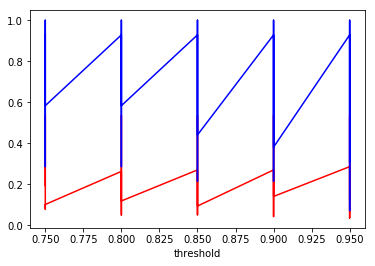

In [38]:
all_hyperparams_2 = {
    LDA_Model_Hyperp.MIN_COSINE_SIMILARITY_THRESHOLD.value : [i/100 for i in range(1,10000,1)],
    LDA_Model_Hyperp.LDA_MODEL_N_COMPONENTS.value: [best_model.lda_model.n_components],
    LDA_Model_Hyperp.LDA_MODEL_RANDOM_STATE.value : [best_model.lda_model.random_state],
    LDA_Model_Hyperp.VECTORIZER_NGRAM_RANGE.value: [best_model.vectorizer.ngram_range],
    LDA_Model_Hyperp.VECTORIZER.value : [best_model.vectorizer],
    LDA_Model_Hyperp.VECTORIZER_TOKENIZER.value : [best_model.vectorizer.tokenizer]
}

hyperparams = generate_params_comb_list(**all_hyperparams)

dic = {'precision':[], 'recall':[], 'threshold':[]}

for hyperp in hyperparams:
    current_model = LDA(**hyperp)
    current_model.recover_links(corpus, query, use_cases_names, bug_reports_names)
    
    evaluator = ModelEvaluator(orc.oracle, current_model)
    evaluator.evaluate_model()
    
    dic['precision'].append(evaluator.get_mean_precision())
    dic['recall'].append(evaluator.get_mean_recall())
    dic['threshold'].append(current_model.get_min_cosine_similarity_threshold())

df = pd.DataFrame(dic)

plt.plot(df['threshold'], df['precision'], 'r-')
plt.plot(df['threshold'], df['recall'], 'b-')
plt.xlabel('threshold')
plt.show()